<a href="https://colab.research.google.com/github/JNPauli/Protect_app_master_thesis/blob/main/Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Import X and y

In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
os.chdir('/content/drive/MyDrive/Thesis')

In [5]:
y = np.load('train_con.npy')

In [6]:
y_ = y[0:10000]
y_frames = y[14276:]

In [7]:
y_all = np.concatenate((y_,y_frames))

NEW APPROACH:

Fit CNN on X

1. Read `n-rows`from X.

In [8]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [9]:
X = np.load('X_npy.npy')

In [10]:
X_train_,X_test_,y_train_,y_test_ = train_test_split(X,y_,test_size=0.2,random_state=42)

In [11]:
del X,y_
gc.collect()

0

In [12]:
X_frames = np.load('frames_npy.npy')

In [13]:
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_frames,y_frames,test_size=0.2,random_state=42)

In [14]:
del X_frames,y_frames
gc.collect()

11

In [15]:
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2,random_state=42)

Converting X to appropriate Datatype...

In [16]:
X_tensor_train = torch.from_numpy(X_train_)
del X_train_
gc.collect()
X_tensor_test = torch.from_numpy(X_test_)
del X_test_
gc.collect()
#X_tensor_val = torch.from_numpy(X_val)

y_tensor_train = torch.from_numpy(y_train_)
del y_train_
gc.collect()
y_tensor_test = torch.from_numpy(y_test_)
del y_test_
gc.collect()
#y_tensor_val = torch.from_numpy(y_val)

0

In [17]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
#X_tensor_val = torch.tensor(X_tensor_val,dtype=torch.float32)

y_tensor_train = y_tensor_train.type(torch.LongTensor)
y_tensor_test = y_tensor_test.type(torch.LongTensor)
#y_tensor_val = y_tensor_val.type(torch.LongTensor)

<ipython-input-17-b2abd24c48fc>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
<ipython-input-17-b2abd24c48fc>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)


Pytorch needs the true labels to be in the range N-1. Thus, substract 1 one from each label.

In [18]:
y_tensor_train = y_tensor_train-1
y_tensor_test = y_tensor_test-1
#y_tensor_val = y_tensor_val-1

In [19]:
X_tensor_train_ = torch.from_numpy(X_train_f)
del X_train_f
gc.collect()
X_tensor_test_ = torch.from_numpy(X_test_f)
del X_test_f
gc.collect()
#X_tensor_val = torch.from_numpy(X_val)

y_tensor_train_ = torch.from_numpy(y_train_f)
del y_train_f
gc.collect()
y_tensor_test_ = torch.from_numpy(y_test_f)
del y_test_f
gc.collect()
#y_tensor_val = torch.from_numpy(y_val)

0

In [20]:
X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)
#X_tensor_val = torch.tensor(X_tensor_val,dtype=torch.float32)

y_tensor_train_ = y_tensor_train_.type(torch.LongTensor)
y_tensor_test_ = y_tensor_test_.type(torch.LongTensor)
#y_tensor_val = y_tensor_val.type(torch.LongTensor)

<ipython-input-20-98aa619a9b76>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
<ipython-input-20-98aa619a9b76>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)


In [21]:
y_tensor_train_ = y_tensor_train_-1
y_tensor_test_ = y_tensor_test_-1

In [22]:
X_tensor_train = torch.cat((X_tensor_train,X_tensor_train_),0)
X_tensor_test = torch.cat((X_tensor_test,X_tensor_test_),0)

y_tensor_train = torch.cat((y_tensor_train,y_tensor_train_),0)
y_tensor_test = torch.cat((y_tensor_test,y_tensor_test_),0)

In [23]:
print('training shape X is {}, test shape X is{}'.format(X_tensor_train.shape,X_tensor_test.shape))

training shape X is torch.Size([13878, 1, 224, 224]), test shape X istorch.Size([3470, 1, 224, 224])


Setup custom dataset class

In [24]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

In [25]:
dataset_train = SimpleDataset(X_tensor_train,y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

#dataset_val = SimpleDataset(X_tensor_val,y_tensor_val)
#dataloader_val = DataLoader(dataset_val,batch_size=32)

dataset_test = SimpleDataset(X_tensor_test,y_tensor_test)
dataloader_test = DataLoader(dataset_test, batch_size = 32)#,shuffle=True)


Setting up the CNN.

In [40]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(774400, 128)
        self.fc2 = nn.Linear(128, 3)#,10
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
#removed 

In [27]:
SalienceNet = CNN()
SalienceNet.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=774400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()

In [29]:
cont_loss = ContinuousLoss_L2()

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
def analysis(net, loss_fn, dataloader_train,dataloader_test,
          epoch=100, learning_rate=0.001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting
    train_loss = []
   
    train_total_loss = []
    train_accuracy = []
    for i in range(epoch):
        total,correct = 0,0
        
        net.to(device)   
        net.train()
        for data, label in dataloader_train:
            data, label = data.to(device), label.to(device)
        #make prediction
            output = net(data.float())

            _, y_pred_train = torch.max(output,1) # get predicted train label

            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            #loss = loss_fn(output,torch.max(label.long(), 1)[0])
            loss = loss_fn(output*10,label*10)

            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient udpate.

            #total += label.size(0)
            #correct += (y_pred_train == torch.max(label,1)[0]).sum().item()
            
            train_loss.append(loss.item())
            print('currently processing epoch {}'.format(i))
            #print('batch accuracy of {}'.format(100*(correct/total)))
            
            #if (i + 1) % (epoch // 5) == 0:
             #print(f'iteration {i + 1}/{epoch} | loss: {loss.item():.3f}')
    

    #train_accuracy.append(correct/total)

    net.eval()
    test_loss = []
    test_total,test_correct = 0,0
    test_acc = []
    for data, labels in dataloader_test:
        print('testing...')

        data, labels = data.to(device), labels.to(device)
        outputs = net(data.float())

        _, y_pred_test = torch.max(outputs,1) # get predicted label for test

        
        #test_l = loss_fn(outputs,torch.max(labels.long(), 1)[0])
        test_l = loss_fn(outputs*10,labels*10)
        test_loss.append(test_l.item())

        #test_total += labels.size(0)
        #test_correct += (y_pred_test==torch.max(labels,1)[0]).sum().item()
        
    #test_acc.append(test_correct/test_total)
    #y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)

   # print('test acc is {}'.format(test_acc))

    return train_loss,test_loss#,train_accuracy,test_acc 


In [32]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [33]:
import matplotlib.pyplot as plt

In [34]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})''')) 

<IPython.core.display.Javascript object>

In [35]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,test_loss=analysis(net=SalienceNet,loss_fn=cont_loss,dataloader_train=dataloader_train,
                  dataloader_test=dataloader_test,epoch=10)




currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently processing epoch 0
currently proc

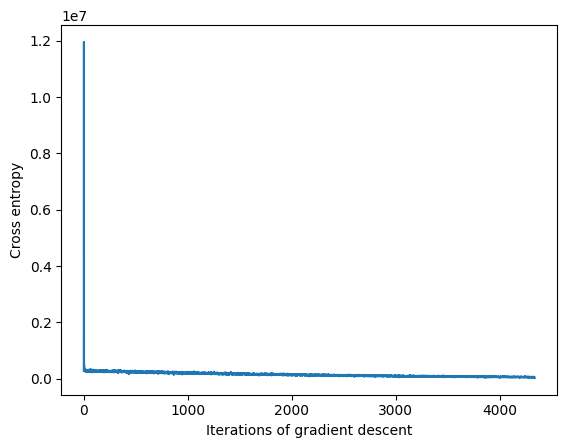

In [36]:
plt.plot(train_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('')
plt.show()

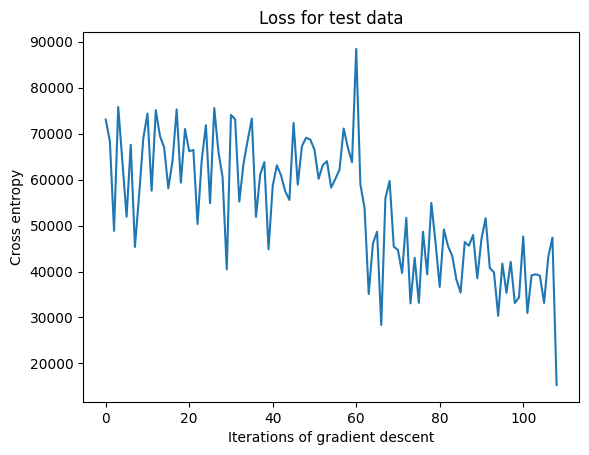

In [37]:
plt.plot(test_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('Cross entropy')
plt.title('Loss for test data')
plt.show()

In [39]:
print('training accuracy is {}'.format(train_acc))
print('test accuracy is {}'.format(test_acc))

NameError: ignored